<a href="https://colab.research.google.com/github/devxkrxshna/Denoising-Autoencoder/blob/main/DAE_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import random as rd
import os
from PIL import Image
import cv2


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.metrics import accuracy


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist

In [6]:
#setting seed for reproducability
from numpy.random import seed
seed(25)
np.random.seed(50)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
source="https://www.kaggle.com/code/krinapanchal/vgg16-implementation" #code source for reference
Drivelink="https://drive.google.com/drive/folders/119twOXj4rydtZDwPOwLq3UVZ6D5u-8Nf?usp=sharing" #drive link to mri barin dataset 

In [9]:
data= [] #creating a list for images
paths = [] #creating list for paths
for r, d, f in os.walk(r'/content/drive/MyDrive/Colab Notebooks/brain_images_2000'): #OS.walk() generate the file names in a directory tree by walking the tree, tuple (dirpath, dirnames, filenames). update the path of your respective folder in drive
    for file in f:
        if '.jpg' or '.jpeg' or '.JPG' or '.png' in file:
            paths.append(os.path.join(r, file))


In [10]:
for path in paths:
    img = Image.open(path)  
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))

In [11]:
#test data
data_test = [] #creating a list for images
paths_test = [] #creating list for paths
for r, d, f in os.walk(r'/content/drive/MyDrive/Colab Notebooks/brain_mri_400'): #OS.walk() generate the file names in a directory tree by walking the tree, tuple (dirpath, dirnames, filenames). update the path of your respective folder in drive
    for file in f:
        if '.jpg' or '.jpeg' or '.JPG' or '.png' in file:
            paths_test.append(os.path.join(r, file))

In [12]:
#test data
for path in paths_test:
    img = Image.open(path)  
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))

In [13]:
data = np.array(data)
print('data shape is:', data.shape) ##we have 1837 images with 128 height, 128 width, RGB color channel



data shape is: (2146, 128, 128, 3)


In [14]:
data_test = np.array(data_test)
print('data shape is:', data_test.shape)

data shape is: (173, 128, 128, 3)


In [15]:
#Each pixel has a value between 255 and 0. We will reduce this down to 1 and 0 in order to help the neural network converge quicker.
#getting the max of the array
print(np.max(data))
#getting the min of the array
print(np.min(data))


#reducing the data to between 1 and 0
data = data / 255.00
#getting the max of the array
print(np.max(data))
#getting the min of the array
print(np.min(data))

#print(data)

255
0
1.0
0.0


In [16]:
#test data normalization

print(np.max(data_test))
#getting the min of the array
print(np.min(data_test))


#reducing the data to between 1 and 0
data_test = data_test / 255.00
#getting the max of the array
print(np.max(data_test))
#getting the min of the array
print(np.min(data_test))

#print(data)

255
0
1.0
0.0


In [17]:
data=tf.convert_to_tensor(data)
data.shape

TensorShape([2146, 128, 128, 3])

In [18]:
data_test=tf.convert_to_tensor(data_test)
data_test.shape

TensorShape([173, 128, 128, 3])

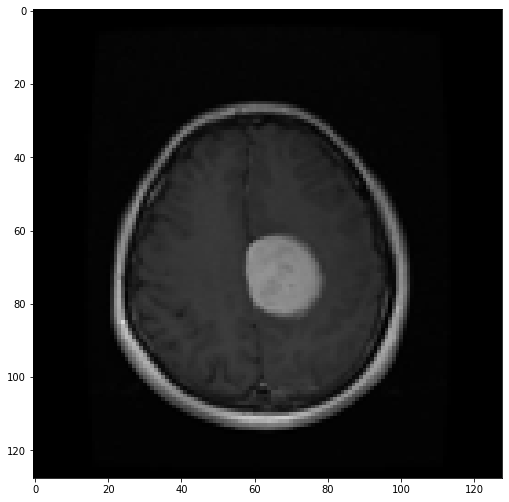

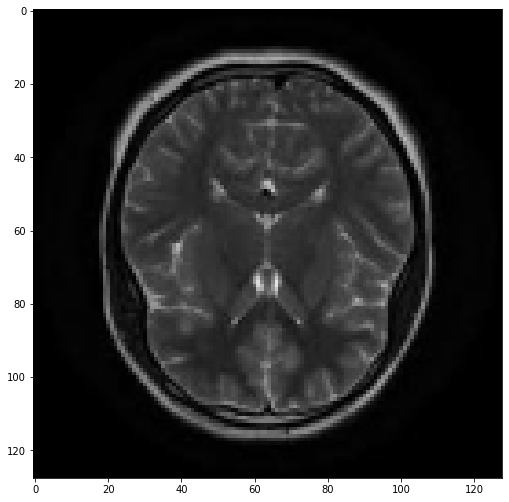

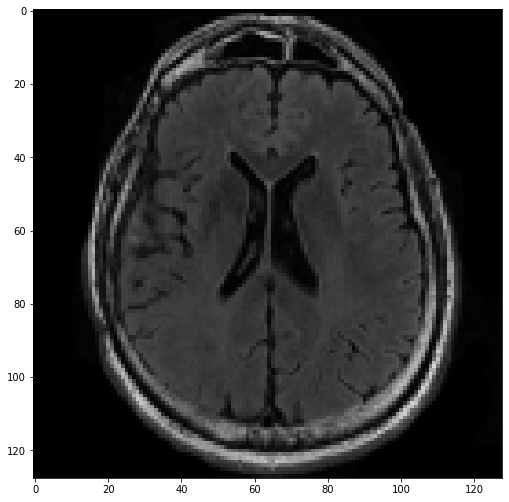

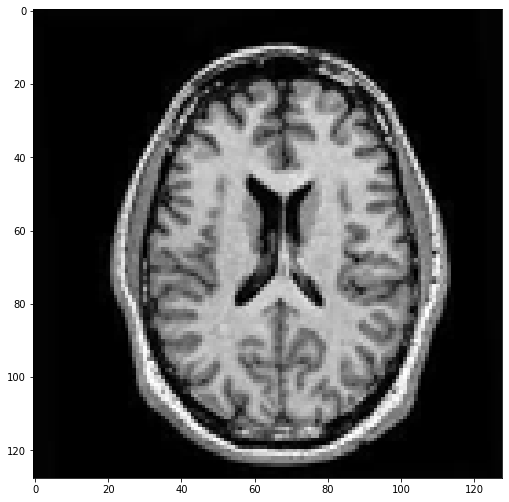

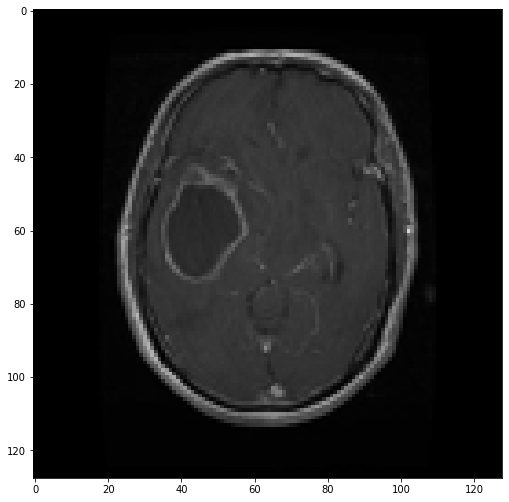

In [19]:
for i in range(5):
    fig = plt.figure(figsize=(50,50))
    plt.subplot(5,5,i+1)
    image = plt.imshow(data[i])
    plt.show(image)

In [20]:
new_dataset="https://www.kaggle.com/datasets/darren2020/ct-to-mri-cgan"

**Average method**: The Average method takes the average value of R, G, and B as the grayscale value. 
Grayscale = (R + G + B ) / 3

In [40]:
noise_factor =0.3
data_noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
data_noisy = np.clip(data_noisy, 0., 1.)

In [41]:
#addimg noise to test data
noise_factor =0.3
data_test_noisy = data_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data_test.shape)
data_test_noisy = np.clip(data_test_noisy, 0., 1.)

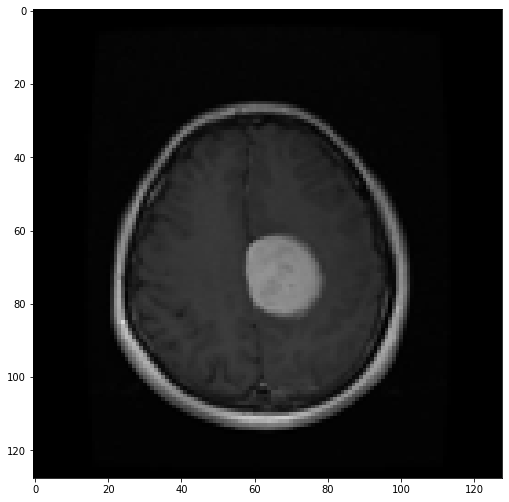

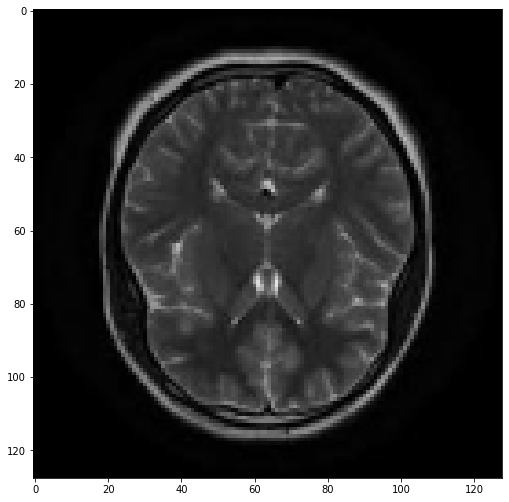

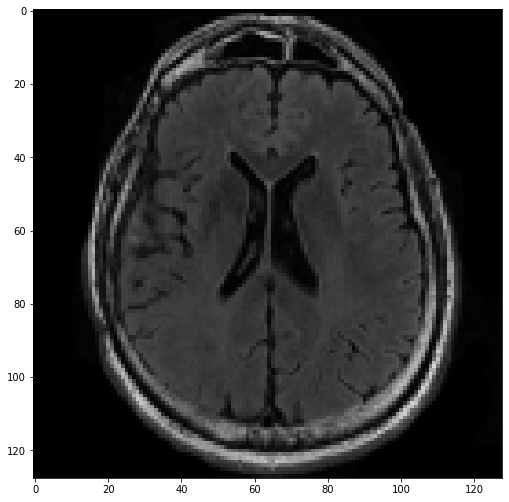

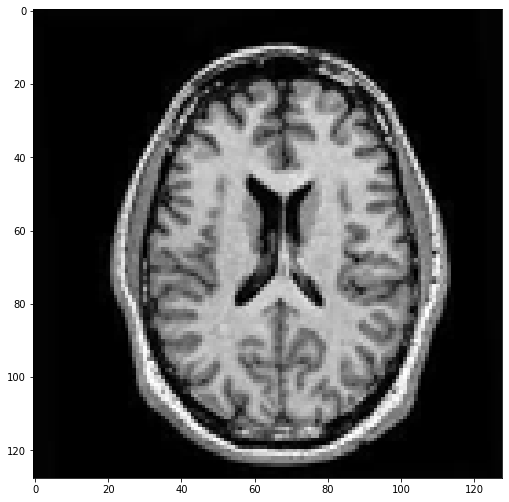

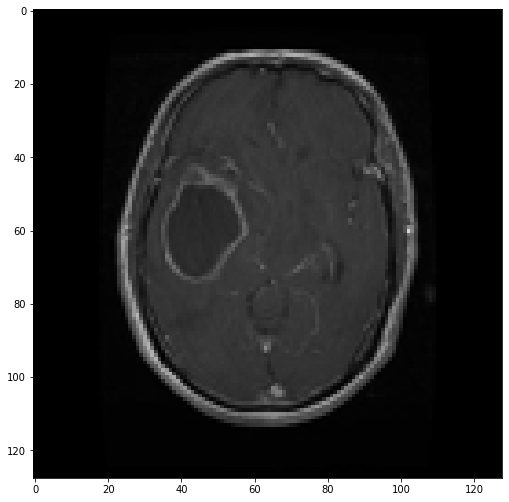

In [42]:
for i in range(5):
    fig = plt.figure(figsize=(50,50))
    plt.subplot(5,5,i+1)
    image = plt.imshow(data[i])
    plt.show(image)

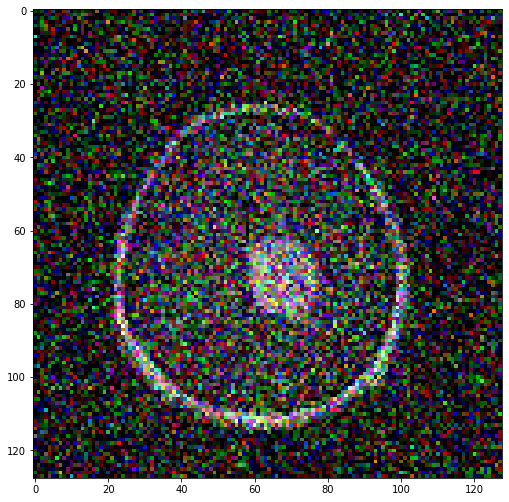

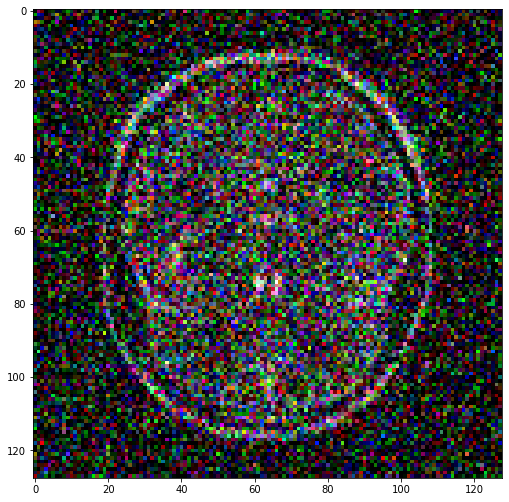

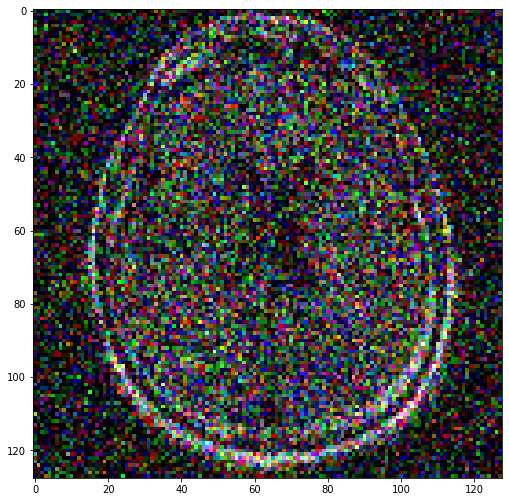

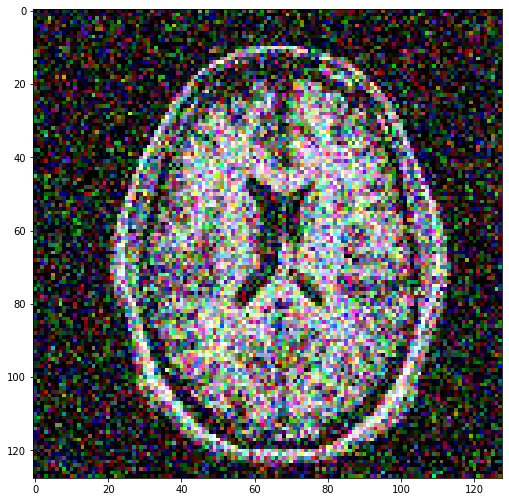

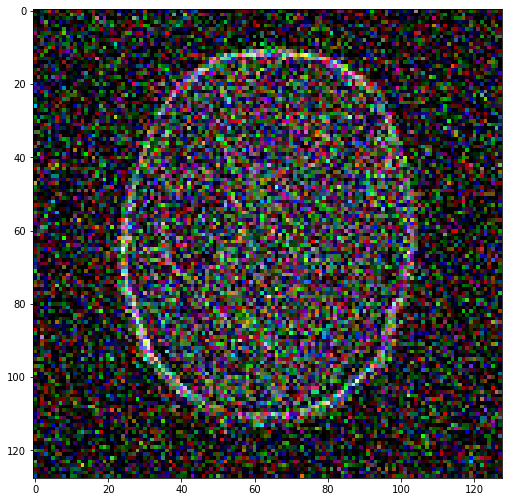

In [43]:
for i in range(5):
    fig = plt.figure(figsize=(50,50))
    plt.subplot(5,5,i+1)
    image = plt.imshow(data_noisy[i])
    plt.show(image)

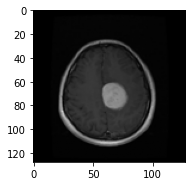

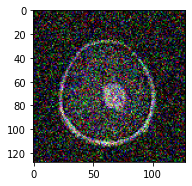

In [44]:
plt.subplot(1,2,1)
#fig = plt.figure(figsize=(10,10))
image1 = plt.imshow(data[0])
plt.show(image1)
plt.subplot(1,2,2)
image2 = plt.imshow(data_noisy[0])
plt.show(image2)


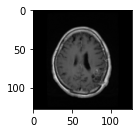

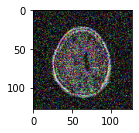

In [45]:
plt.subplot(2,2,1)
#fig = plt.figure(figsize=(10,10))
image1 = plt.imshow(data_test[0])
plt.show(image1)
plt.subplot(2,2,2)
image2 = plt.imshow(data_test_noisy[0])
plt.show(image2)



In [27]:
# print(data_test[0])

In [46]:
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose

In [29]:
source="https://github.com/aswintechguy/Deep-Learning-Projects/blob/main/Autoencoder%20-%20Deep%20CNN/Deep%20CNN%20Autoencoder%20-%20Denoising%20Image.ipynb"

In [47]:
model_1 = Sequential([
                    # encoder network
                    Conv2D(32, 3, activation='relu', padding='same', input_shape=(128, 128, 3)),
                    MaxPooling2D(2, padding='same'),
                    Conv2D(16, 3, activation='relu', padding='same'),
                    MaxPooling2D(2, padding='same'),
                    # decoder network
                    Conv2D(16, 3, activation='relu', padding='same'),
                    UpSampling2D(2),
                    Conv2D(32, 3, activation='relu', padding='same'),
                    UpSampling2D(2),
                    # output layer
                    Conv2D(3, 3, activation='sigmoid', padding='same')
])

model_1.compile(optimizer='adam', loss='binary_crossentropy')
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 64, 64, 16)      

In [63]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)

In [64]:
history = model_1.fit(
    x = data_noisy,
    y = data,
    validation_data= (data_test_noisy,data_test),
    batch_size = 32,
    epochs=200,
    callbacks=[callback]

)

Epoch 1/200
68/68 [==============================] - 2s 36ms/step - loss: 0.3601 - val_loss: 0.3526
Epoch 2/200
68/68 [==============================] - 2s 34ms/step - loss: 0.3601 - val_loss: 0.3525
Epoch 3/200
68/68 [==============================] - 2s 33ms/step - loss: 0.3599 - val_loss: 0.3524
Epoch 4/200
68/68 [==============================] - 2s 33ms/step - loss: 0.3599 - val_loss: 0.3524
Epoch 5/200
68/68 [==============================] - 2s 34ms/step - loss: 0.3598 - val_loss: 0.3523
Epoch 6/200
68/68 [==============================] - 2s 34ms/step - loss: 0.3598 - val_loss: 0.3529
Epoch 7/200
68/68 [==============================] - 3s 39ms/step - loss: 0.3599 - val_loss: 0.3523
Epoch 8/200
68/68 [==============================] - 2s 34ms/step - loss: 0.3597 - val_loss: 0.3523
Epoch 9/200
68/68 [==============================] - 2s 33ms/step - loss: 0.3596 - val_loss: 0.3525
Epoch 10/200
68/68 [==============================] - 2s 34ms/step - loss: 0.3595 - val_loss: 0.3521

6/6 [==============================] - 0s 9ms/step
shape of test data: (173, 128, 128, 3)


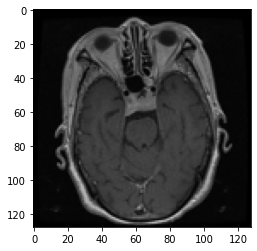

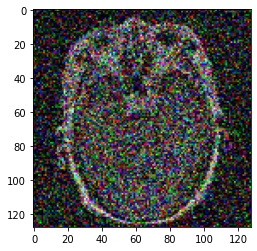

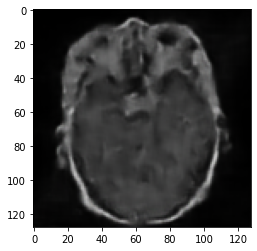

In [65]:
#test data
pred = model_1.predict(data_test_noisy)
print("shape of test data:",pred.shape)
plt.imshow(data_test[2])
plt.show()
plt.imshow(data_test_noisy[2])
plt.show()
plt.imshow(pred[2].reshape(128,128,3))
plt.show()


68/68 [==============================] - 1s 10ms/step
(2146, 128, 128, 3)


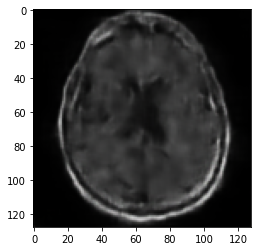

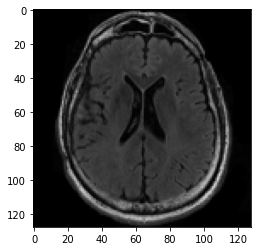

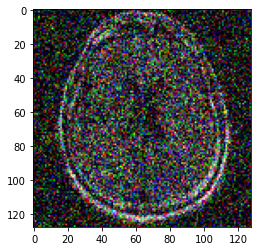

In [66]:
#predicting on train data to feed it again to the next DAE, ie. CASCADING
pred_train = model_1.predict(data_noisy)
print(pred_train.shape)
plt.imshow(pred_train[2].reshape(128,128,3)) #predicted data
plt.show()
plt.imshow(data[2]) #original
plt.show()
plt.imshow(data_noisy[2]) #noise added
plt.show()


In [67]:
from skimage.metrics import structural_similarity
import cv2


In [68]:
data_test = np.array(data_test)
pred=np.array(pred)

In [69]:
#SSIM on predicted test data
(score, diff) = structural_similarity(data_test, pred, full=True,multichannel=True)
print("Image similarity", score)


Image similarity 0.9290718766276256


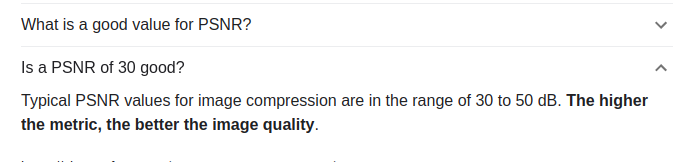

In [72]:

#calculated the PSNR (peak-signal-to-noise-ratio)
def PSNR(data_test, pred):
    mse = np.mean(255*(data_test - pred) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) #converting to DB
    return psnr


In [73]:
value = PSNR(data_test, pred)
print(f"PSNR value is {value} dB")

PSNR value is 48.08915644639262 dB


 Autoencoders are made up of two parts (Encoders and Decoders). Autoencoders decrease the number of variables required to store the Information, and Decoders try to get this information back from the compressed form. (Note that autoencoders are not used in real data compression tasks, due to their uncertainty and their data dependent nature).

# cascading DAE